In [2]:
# Установка зависимостей (если нужно)
!pip install transformers datasets scikit-learn

In [3]:
!pip install --upgrade datasets fsspec huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [5]:
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
import torch

# Загрузка датасета IMDb
dataset = load_dataset('imdb')

# Токенизация
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets.set_format('torch')

small_train = tokenized_datasets['train'].shuffle(seed=42).select(range(4000))
small_test = tokenized_datasets['test'].shuffle(seed=42).select(range(1000))

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import random

def sample_hyperparams():
    return {
        'learning_rate': 10**np.random.uniform(-6, -4.3),
        'per_device_train_batch_size': random.choice([8, 16]),
        'num_train_epochs': random.choice([2, 3]),
        'warmup_steps': random.choice([0, 100, 500])
    }

In [10]:
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    accuracy = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [12]:
results = []

for i in range(5):
    params = sample_hyperparams()
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    training_args = TrainingArguments(
        output_dir=f'./results_{i}',
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['per_device_train_batch_size'],
        per_device_eval_batch_size=16,
        num_train_epochs=params['num_train_epochs'],
        warmup_steps=params['warmup_steps'],
        logging_dir=f'./logs_{i}',
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train,
        eval_dataset=small_test,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()

    # Сохраняем параметры и метрики
    result = {
        **params,
        **{k: eval_result[f'eval_{k}'] for k in ['accuracy', 'precision', 'recall', 'f1']}
    }
    results.append(result)

    print(f'Run {i+1}: accuracy={eval_result["eval_accuracy"]:.4f}, params={params}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.687000
20,0.631100
30,0.524900
40,0.373800
50,0.340600
60,0.433300
70,0.356600
80,0.322900
90,0.226300
100,0.419700


Run 1: accuracy=0.8880, params={'learning_rate': 4.1325138797415965e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'warmup_steps': 0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.690800
20,0.702000
30,0.685400
40,0.692000
50,0.694600
60,0.733300
70,0.728100
80,0.693500
90,0.706400
100,0.702600


Run 2: accuracy=0.8550, params={'learning_rate': 4.332296801195363e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'warmup_steps': 500}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.690800
20,0.702000
30,0.685400
40,0.692000
50,0.694600
60,0.733300
70,0.728100
80,0.693500
90,0.706400
100,0.702600


Run 3: accuracy=0.8550, params={'learning_rate': 4.332296801195363e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'warmup_steps': 500}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.690800
20,0.702000
30,0.685400
40,0.692000
50,0.694600
60,0.733300
70,0.728100
80,0.693500
90,0.706400
100,0.702600


Run 4: accuracy=0.8550, params={'learning_rate': 4.332296801195363e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'warmup_steps': 500}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.690800
20,0.702000
30,0.685400
40,0.692000
50,0.694600
60,0.733300
70,0.728100
80,0.693500
90,0.706400
100,0.702600


Run 5: accuracy=0.8550, params={'learning_rate': 4.332296801195363e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'warmup_steps': 500}


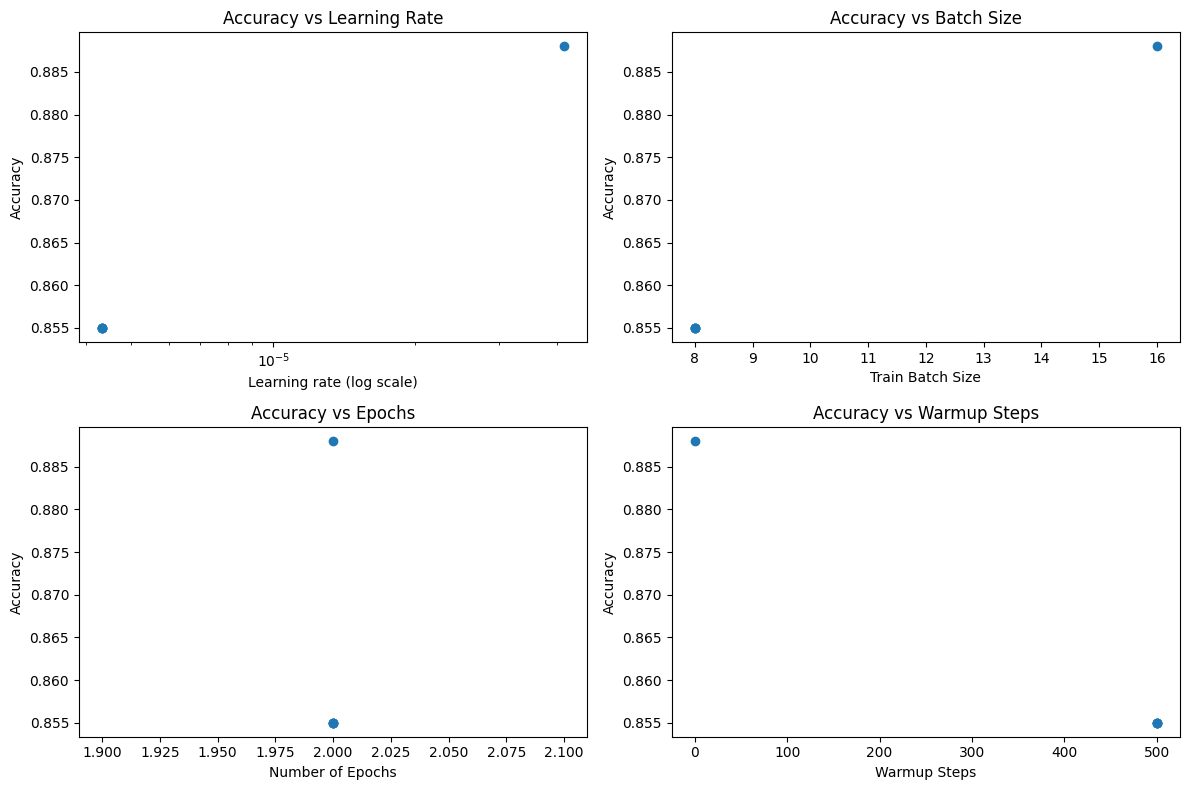

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Преобразуем результаты в DataFrame
df = pd.DataFrame(results)

# Графики зависимости accuracy от гиперпараметров
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.scatter(df['learning_rate'], df['accuracy'])
plt.xscale('log')
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')

plt.subplot(2,2,2)
plt.scatter(df['per_device_train_batch_size'], df['accuracy'])
plt.xlabel('Train Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')

plt.subplot(2,2,3)
plt.scatter(df['num_train_epochs'], df['accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

plt.subplot(2,2,4)
plt.scatter(df['warmup_steps'], df['accuracy'])
plt.xlabel('Warmup Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Warmup Steps')

plt.tight_layout()
plt.show()

In [14]:
print("Средние значения метрик:")
print(df[['accuracy', 'precision', 'recall', 'f1']].mean())

print("\nДисперсии метрик:")
print(df[['accuracy', 'precision', 'recall', 'f1']].var())


Средние значения метрик:
accuracy     0.861600
precision    0.851373
recall       0.868033
f1           0.859615
dtype: float64

Дисперсии метрик:
accuracy     0.000218
precision    0.000295
recall       0.000142
f1           0.000213
dtype: float64


In [15]:
best_run = df.loc[df['accuracy'].idxmax()]
print("\n=== Отчет по результатам экспериментов ===")
print(f"Лучший run с accuracy={best_run['accuracy']:.4f}")
print(f"Параметры: learning_rate={best_run['learning_rate']:.2e}, batch_size={best_run['per_device_train_batch_size']}, epochs={best_run['num_train_epochs']}, warmup_steps={best_run['warmup_steps']}")
print(f"Precision: {best_run['precision']:.4f}, Recall: {best_run['recall']:.4f}, F1: {best_run['f1']:.4f}")

print("\nРекомендации:")
print("- Обучение с learning_rate около {:.2e} даёт лучшие результаты.".format(best_run['learning_rate']))
print("- Batch size {} является оптимальным среди протестированных.".format(int(best_run['per_device_train_batch_size'])))
print("- Количество эпох {} достаточное для данной задачи.".format(int(best_run['num_train_epochs'])))
print("- Warmup steps {} может влиять на стабильность обучения.".format(int(best_run['warmup_steps'])))
print("\nВ целом, модель показывает стабильные результаты с точностью около {:.2f}% на тестовой выборке.".format(best_run['accuracy']*100))


=== Отчет по результатам экспериментов ===
Лучший run с accuracy=0.8880
Параметры: learning_rate=4.13e-05, batch_size=16.0, epochs=2.0, warmup_steps=0.0
Precision: 0.8821, Recall: 0.8893, F1: 0.8857

Рекомендации:
- Обучение с learning_rate около 4.13e-05 даёт лучшие результаты.
- Batch size 16 является оптимальным среди протестированных.
- Количество эпох 2 достаточное для данной задачи.
- Warmup steps 0 может влиять на стабильность обучения.

В целом, модель показывает стабильные результаты с точностью около 88.80% на тестовой выборке.


Улучшить: увеличить количество запусков для более надёжной оценки влияния гиперпараметров и повышения вероятности нахождения оптимальных настроек.